In [1]:
import os
# import glob
# import h5py
# import shutil
# import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.image as mimg
# import imgaug.augmenters as iaa
# from os import listdir, makedirs, getcwd, remove
# from os.path import isfile, join, abspath, exists, isdir, expanduser
# from PIL import Image
from pathlib import Path
import tensorflow as tf
# from skimage.io import imread
# from skimage.transform import resize
# from keras.models import Sequential, Model
# from keras.applications.vgg16 import VGG16, preprocess_input
# from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, BatchNormalization
from keras.layers import GlobalMaxPooling2D
# from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from tensorflow.python.keras import layers, models, optimizers, callbacks
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline


In [2]:
# import tensorflow as tf

# # Set the seed for hash based operations in python
# os.environ['PYTHONHASHSEED'] = '0'

# # Set the numpy seed
# np.random.seed(111)


# # Set the random seed in tensorflow at graph level
# tf.random.set_seed(111)

# import tensorflow as tf
# from tensorflow.compat.v1.keras.backend import set_session

# # Assuming you already have a TensorFlow session 'sess'
# sess = tf.compat.v1.Session()

# # Set the session
# set_session(sess)

In [3]:
# data_dir = Path('/content/drive/MyDrive/DR')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = Path('Final')

# # Path to validation directory
# val_dir = data_dir / 'val'

# # Path to test directory
# test_dir = data_dir / 'test'

In [4]:
dir_arr = np.empty((5,), dtype=Path)
for i in range(0,5):
  dir_arr[i] = train_dir / f'{i}'

In [5]:
train_data = []
for i in range(0,5):
  for img in os.listdir(dir_arr[i]):
      train_data.append((dir_arr[i] / img,i))

In [6]:

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,Final\0\1313_left.jpeg,0
1,Final\4\23648_right.jpeg,4
2,Final\1\1999_left_augmented_1.jpg,1
3,Final\1\25236_left_augmented_1.jpg,1
4,Final\1\13209_left_augmented_0.jpg,1


In [7]:
train_data[train_data['label'] == 4]

,image,label
1,Final\4\23648_right.jpeg,4
7,Final\4\16565_left_augmented_0.jpg,4
8,Final\4\22520_left_augmented_0.jpg,4
13,Final\4\13669_right_augmented_5.jpg,4
24,Final\4\19588_left_augmented_2.jpg,4
...,...,...
30951,Final\4\7853_right_augmented_0.jpg,4
30953,Final\4\10193_right_augmented_0_f.jpg,4
30962,Final\4\37958_left_augmented_2.jpg,4
30983,Final\4\30723_left_augmented_3.jpg,4


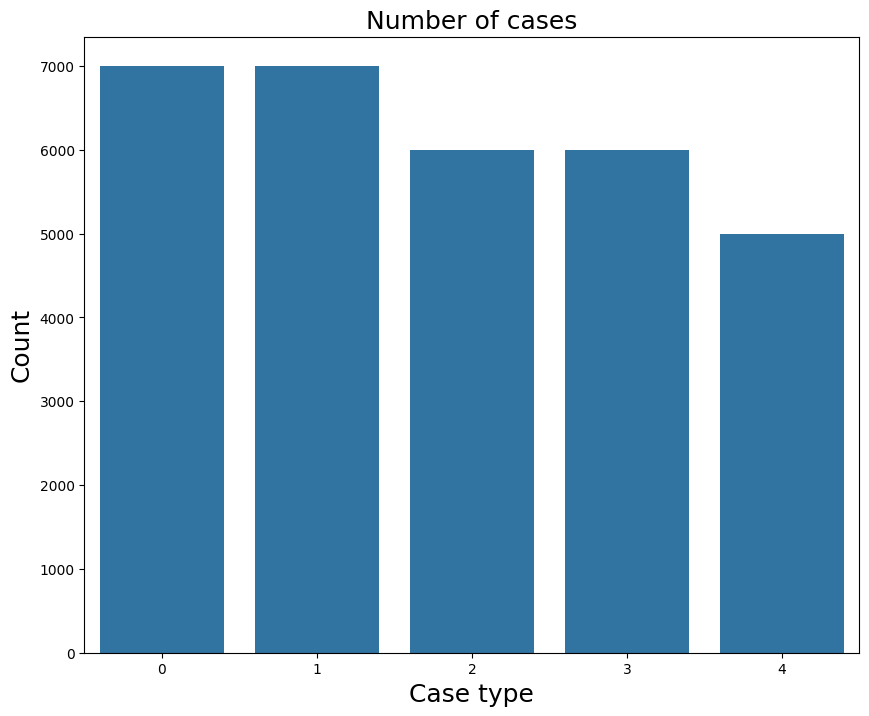

In [8]:
cases_count = train_data['label'].value_counts()
# Plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=18)
plt.xlabel('Case type', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(range(len(cases_count.index)), [str(i) for i in range(0,5)])
plt.show()

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
def res(img,wid=256):
  height, width = img.shape[:2]
  aspect_ratio = width / height
  desired_height = int(wid / aspect_ratio)

  # Resize the image while maintaining the aspect ratio
  resized_img = cv2.resize(img, (wid, desired_height))
  return resized_img

def samp(pt):
# Read the image
    img = cv2.imread(pt)
    print(type(img))
    # Calculate the new height to maintain the aspect ratio


    # Display the resized image using cv2_imshow
    cv2.imshow('wd',res(img))
    cv2.waitKey(0)
    cv2.destroyAllWindows() 


def rad(image):
  # Calculate the current radius (assuming a square image)
  current_radius = min(image.shape[0], image.shape[1]) / 2

  # Set the target radius
  target_radius = 300.0

  # Calculate the scaling factor
  scaling_factor = target_radius / current_radius

  # Resize the image with the calculated scaling factor
  resized_image = cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)

  # Display the original and resized images
  return resized_image

def filt2(pt):# Load the given image (I1)
  I1 = cv2.imread(pt)
  I1 = rad(I1)
  # Load the original image (I2) to be blurred
  # original_I2 = cv2.imread(pt)
  # original_I2 = rad(original_I2)
  # Apply Gaussian blur to I2
  I2 = cv2.GaussianBlur(I1, (25,25), 18)



  # Perform the operation I = 4I1 - 4I2 + 128
  result_image = 4 * I1 - 4 * I2 + 128

  # Clip the result to ensure pixel values are within the valid range [0, 255]
  result_image = np.clip(result_image, 0, 255).astype(np.uint8)
  I2 = res(I2)
  I1 = res(I1)
  # result_image = res(result_image)
  # original_I2 = res(original_I2)
  # # cv2_imshow(I1)
  # # cv2_imshow(I2)
  # # Create a 2x2 subplot grid
  # plt.subplot(2, 2, 1), plt.imshow(cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)), plt.title('I1')
  # plt.subplot(2, 2, 2), plt.imshow(cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)), plt.title('I2')
  # # plt.subplot(2, 2, 3), plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)), plt.title('Result Image')
  # plt.subplot(2, 2, 4), plt.imshow(cv2.cvtColor(original_I2, cv2.COLOR_BGR2RGB)), plt.title('Original I2 (Blurred)')
  # # Adjust layout for better visualization
  # plt.tight_layout()
  # # Show the plot
  # plt.show()
  return result_image

def cut(image):
  # Read the image

    # Get the center coordinates of the image
  center_x, center_y = image.shape[1] // 2, image.shape[0] // 2

  # Define the size of the crop
  crop_size = 256

  # Calculate the region to crop around the center while maintaining aspect ratio
  start_x = max(0, center_x - crop_size // 2)
  start_y = max(0, center_y - crop_size // 2)
  end_x = min(image.shape[1], center_x + crop_size // 2)
  end_y = min(image.shape[0], center_y + crop_size // 2)

  # Crop the image
  cropped_image = image[start_y:end_y, start_x:end_x]
  # Resize the cropped image to exactly 256 x 256 pixels
  # cropped_image = cv2.resize(cropped_image, (256, 256))

  # Save the cropped image
  return cropped_image

def cut_after_filt(img):
  height, width = img.shape[:2]
  aspect_ratio = width / height
  desired_width = int(256 * aspect_ratio)
  resized_img = cv2.resize(img, (desired_width, 256))
  return cut(resized_img)

def pre_pro(img):
  return cut_after_filt(filt2(img))

In [10]:
valid_data = []
valid_labels = []

for i in range(0,5):
    for img in os.listdir(f'Val/{i}'):
        # img = pre_pro(f'Val/{i}'+'/'+img)
        img = cv2.imread(f'Val/{i}'+'/'+img)
        img = cv2.resize(img,(224,224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.
        label = to_categorical(0, num_classes=5)
        valid_data.append(img)
        valid_labels.append(label)

# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (250, 224, 224, 3)
Total number of labels: (250, 5)


In [11]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size

    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 256, 256, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,5), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)

    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']

            # one hot encoding
            encoded_label = to_categorical(label, num_classes=5)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (256,256))

            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            count+=1

            if count==batch_size-1:
                break

        i+=1
        yield batch_data, batch_labels

        if i>=steps:
            i=0

In [12]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras import layers, models

# # Load pre-trained VGG16 model without the top (fully connected) layers
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.summary()

In [13]:
def build_model():
    input_img = Input(shape=(256,256,3), name='ImageInput')
    x = Conv2D(64, (7,7), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (5,5), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((3,3), name='pool1')(x)

    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    # x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    # x = BatchNormalization(name='bn3')(x)
    # x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    # x = BatchNormalization(name='bn4')(x)
    # x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    # x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    # x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    # x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)

    model = Model(inputs=input_img, outputs=x)
    return model

In [14]:
model =  build_model()
# for i in [1,2,4,5]:
#     model.layers[i] = base_model.layers[i]
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 256, 256, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 256, 256, 64)      9472      
                                                                 
 Conv1_2 (Conv2D)            (None, 256, 256, 64)      102464    
                                                                 
 pool1 (MaxPooling2D)        (None, 85, 85, 64)        0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 85, 85, 128)       8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 85, 85, 128)       17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 42, 42, 128)       0   

In [15]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

opt = Adam(learning_rate=lr_schedule)


es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [16]:
batch_size = 50
nb_epochs = 30

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training steps: {}".format(nb_train_steps))

Number of training steps: 620


In [17]:
history = model.fit(train_data_gen, epochs=nb_epochs,validation_data=(valid_data, valid_labels) ,steps_per_epoch=nb_train_steps,callbacks=[es, chkpt])

Epoch 1/30


446/620 [====================>.........] - ETA: 29:00 - loss: 1.5848 - accuracy: 0.2286

KeyboardInterrupt: 

In [ ]:
test_loss, test_score = model.evaluate(valid_data, valid_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

16/16 [==============================] - 1s 69ms/step - loss: 0.3952 - accuracy: 0.7960
Loss on test set:  0.39523619413375854
Accuracy on test set:  0.7960000038146973
